# A very simple Neural Network in plain NumPy
---

***A stripped down version of 'Numpy deep neural network.ipynb'***

***Original author: Piotr Skalski***  
https://github.com/SkalskiP/ILearnDeepLearning.py.git

This is a minimal example of a fully operational neural network using only NumPy.

## Imports

In [1]:
import numpy as np
from IPython.display import Image

## Initialization of neural network layers

A small datastructure describing our NN architecture. Each item in the list is a dictionary describing the basic parameters of a single network layer: input_dim = the size of the vector of values input to the layer, output_dim = the size of the activation vector obtained at the output of the layer, and activation = the activation function used inside the layer.

In [2]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 2, "activation": "sigmoid"}, # [X1, X2] -> [H1, H2]
    {"input_dim": 2, "output_dim": 1, "activation": "sigmoid"}, # [H1, H2] -> Y
]

## Initialization of parameter values for each layer

The initial neural network weights shouldn't all be equal. By initializing the weights to random values, we ensure that each neuron will respond differently to a given input. If all neurons respond identically, and thus their contributions to the activation of downstream neurons are all equal, it can be difficult for the training process to break out of this symmetric state, since backpropagated updates based on their contributions will also be equal.

The use of small values increases the efficiency of the backprop algorithm during early iterations. From the graph of the sigmoid function, shown in Figure 4, we can see that its derivative gives higher value for numbers close to zero, which has a significant effect on the speed of learning of our NN. Parameter initiation using small random numbers is a simple approach, but it provides a good enough starting point for our algorithm.

Prepared parameters values are stored in a python dictionary with a key that identifies the layer to which they belong.

In [3]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.0   # 0.1
        

    print("initial param values =", params_values)
    return params_values


## Activation functions

Among all the activation functions in use today, there are several very commonly used, simple but powerful ones. Activation functions can often be written in a single line of code, but they give neural nets non-linearity, and thus the representation and learning power that they need. "Without them, our neural network would become a combination of linear functions, so it would be just a linear function itself." There are many activation functions, but here we provide the possibility of using two of them: sigmoid and ReLU. 

We also need to be able to calculate their derivatives for the backpropagation portion of the learning algorithm. For a derivation of the derivative of the sigmoid function, see: https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e

![Activations](./supporting_visualizations/activations.gif)

<b>Figure 4.</b> Activation functions used in the algorithm.

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

## Single layer forward propagation step

Given the input vector from the previous layer, we compute an affine transformation Z and then apply the selected activation function. In NumPy we can leverage vectorization - performing matrix operations for entire layers and a whole batch of examples at once. This eliminates iteration and significantly speeds up the calculations. In addition to the calculated matrix A, our function also returns an intermediate value of Z, which will be needed during the backpropagation step.

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

![Matrix sizes 2](./supporting_visualizations/matrix_sizes_2.png)

## Full forward propagation

With the single_layer_forward_propagation function completed, we can easily build a whole step forward. This is a slightly more complex function, which not only calculates predictions but also organizes and caches a data structure of intermediate values.

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return prediction vector and a dictionary containing intermediate values
    return A_curr, memory

## Calculating cost

In order to monitor our progress and make sure that we are moving in the desired direction, we calculate the value of the loss function. "Generally speaking, the loss function is designed to show how far we are from the 'ideal' solution." It's selected or designed according to the problem we plan to solve, and frameworks such as Keras have many options to choose from. Here we use binary crossentropy, which is appropriate for a classification problem with 2 output classes. Binary crossentropy is defined by the following formulas. To give us more information on how well our neural network is solving the task, we also implement a function that will calculate accuracy.

![Cost Function](./supporting_visualizations/cost_function.gif)

In [32]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

## Calculating accuracy

In [8]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [9]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

## Single layer backward propagation step

People often confuse backward propagation with gradient descent, but in fact these are two separate matters. The purpose of the first is to calculate the gradient effectively, whereas the second uses the calculated gradient to optimize the neural network weights. In NNs, we calculate the gradient of the cost function (discussed earlier) with respect to NN parameters (weights & biases), but backpropagation can be used to calculate derivatives of any function. The essence of this algorithm is the recursive use of the chain rule from differential calculus - for calculating the derivative of a function created by composing other functions whose derivatives we already know. This process - for one network layer - is described by the following formulas. 

Looking at the formulas, it becomes clear why we want to remember the values of the A and Z matrices for intermediate layers in the forward step.

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$



In [10]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

## Full backward propagation

Just like in the case of forward propagation, here we have split the calculations into two separate functions. The first one (single_layer_backward_propatation) focuses on a single layer and boils down to rewriting chain-rule formulas in NumPy. The second one, the full backward propagation algorithm, deals primarily with key juggling to read and update values in three dictionaries. We start by calculating a derivative of the cost function with respect to the prediction vector - which we obtained using forward propagation. This is quite trivial as it only consists of implementing the following formula. Then we iterate backwards through the layers of the network (starting from the last) and calculate the derivatives with respect to all trainable parameters in the network. Ultimately, function returns a python dictionary containing the gradient we are looking for.

$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [11]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    #print(f"Y.shape={Y.shape}, Y_hat.shape={Y_hat.shape}")
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Updating parameter values

The goal of this method is to update network parameters using gradient optimisation = taking small steps in the direction along which the gradient is the steepest, to try to bring our output function closer to a minimum. For this we use two dictionaries provided as function arguments: params_values, which stores the current values of parameters, and grads_values, which stores cost function derivatives calculated with respect to these parameters. Then we apply the following simple update step for each layer. This is a very basic and straightforward optimization algorithm, but it's a great starting point for more advanced optimizers, which you can read about elsewhere.

In [12]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

## Putting things together

In [13]:
def train(X, Y, nn_architecture, epochs, learning_rate, verbose=0, callback=None, randseed=42):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, randseed)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(verbose and i % verbose == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
                #print("Gradient:", grads_values)
                #print("Updated params:", params_values)
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

### Imports

In [14]:
import os

### Create artificial dataset

In [15]:
XOR = np.array( [
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

NAND = np.array( [
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

NOR = np.array( [
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 0]
])

# X = XOR[:,0:2]
# y = XOR[:,2]
# print(y)

X = np.array( [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
print(f"Input= ")
print(X.T)

y = np.array([0, 1, 1, 0])
print(f"Output= ")
print(f" {y}")

Input= 
[[0 0 1 1]
 [0 1 0 1]]
Output= 
 [0 1 1 0]


In [16]:
X.shape

(4, 2)

In [17]:
y.shape

(4,)

### Auxiliary plotting function

In [18]:
# !pip install seaborn

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# this function makes a scatter-plot graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

### Visualization of the data set

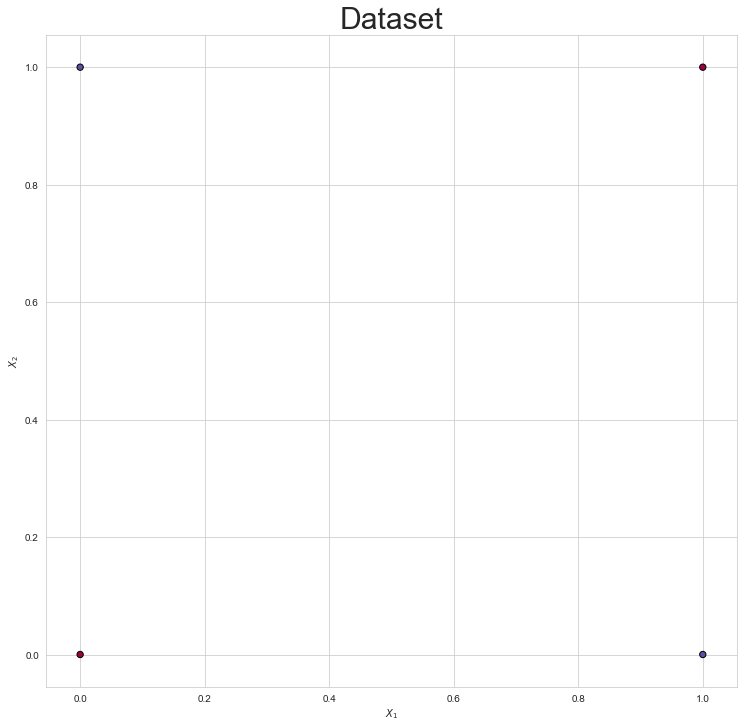

In [21]:
make_plot(X, y, "Dataset")

### Let's put our model to the test

In [22]:
# Training  - for our trivial dataset, train on all the data (all 4 datapoints :-)
X_train = X
X_test = X
y_train = y
y_test = y
print(X_train, X_train.shape)
print(y_train, y_train.shape)


[[0 0]
 [0 1]
 [1 0]
 [1 1]] (4, 2)
[0 1 1 0] (4,)


In [23]:
optimized_params = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))),
                         NN_ARCHITECTURE, 60000, 0.3, verbose=1000, randseed=2)
print(optimized_params)

initial param values = {'W1': array([[-0.04167578, -0.00562668],
       [-0.21361961,  0.16402708]]), 'b1': array([[-0.],
       [-0.]]), 'W2': array([[ 0.05028814, -0.12452881]]), 'b2': array([[-0.]])}
Iteration: 00000 - cost: 0.69332 - accuracy: 0.50000
Iteration: 01000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 02000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 03000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 04000 - cost: 0.69314 - accuracy: 0.50000
Iteration: 05000 - cost: 0.69314 - accuracy: 0.50000
Iteration: 06000 - cost: 0.69314 - accuracy: 0.50000
Iteration: 07000 - cost: 0.69314 - accuracy: 0.50000
Iteration: 08000 - cost: 0.69313 - accuracy: 0.50000
Iteration: 09000 - cost: 0.69311 - accuracy: 0.50000
Iteration: 10000 - cost: 0.69304 - accuracy: 0.50000
Iteration: 11000 - cost: 0.69252 - accuracy: 0.50000
Iteration: 12000 - cost: 0.62317 - accuracy: 0.75000
Iteration: 13000 - cost: 0.05458 - accuracy: 1.00000
Iteration: 14000 - cost: 0.02095 - accuracy: 1.00000
It

In [24]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), optimized_params, NN_ARCHITECTURE)

In [25]:
print(Y_test_hat)

[[6.18373700e-04 9.99422904e-01 9.99142935e-01 5.40109066e-04]]


In [33]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 1.00


## Visualisation of the learning process

### Settings

In [27]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"

### Definition of grid boundaries

In [28]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

### NumPy callback

In [29]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)

In [30]:
# Training
params_optimized = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))),
                         NN_ARCHITECTURE, 20000, 0.5,
                         verbose=500, 
                        callback=callback_numpy_plot, randseed=42)
print(params_optimized)

initial param values = {'W1': array([[ 0.04967142, -0.01382643],
       [ 0.06476885,  0.15230299]]), 'b1': array([[-0.],
       [-0.]]), 'W2': array([[0.15792128, 0.07674347]]), 'b2': array([[-0.]])}
Iteration: 00000 - cost: 0.69495 - accuracy: 0.50000


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app


Iteration: 00500 - cost: 0.69315 - accuracy: 0.50000
Iteration: 01000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 01500 - cost: 0.69315 - accuracy: 0.50000
Iteration: 02000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 02500 - cost: 0.69315 - accuracy: 0.50000
Iteration: 03000 - cost: 0.69315 - accuracy: 0.50000
Iteration: 03500 - cost: 0.69315 - accuracy: 0.50000
Iteration: 04000 - cost: 0.69314 - accuracy: 0.50000
Iteration: 04500 - cost: 0.69314 - accuracy: 0.50000
Iteration: 05000 - cost: 0.69314 - accuracy: 0.75000
Iteration: 05500 - cost: 0.69314 - accuracy: 0.75000
Iteration: 06000 - cost: 0.69313 - accuracy: 0.75000
Iteration: 06500 - cost: 0.69312 - accuracy: 0.75000
Iteration: 07000 - cost: 0.69307 - accuracy: 0.75000
Iteration: 07500 - cost: 0.69260 - accuracy: 0.75000
Iteration: 08000 - cost: 0.64715 - accuracy: 0.75000
Iteration: 08500 - cost: 0.18180 - accuracy: 1.00000
Iteration: 09000 - cost: 0.03736 - accuracy: 1.00000
Iteration: 09500 - cost: 0.01954 - accuracy: 1

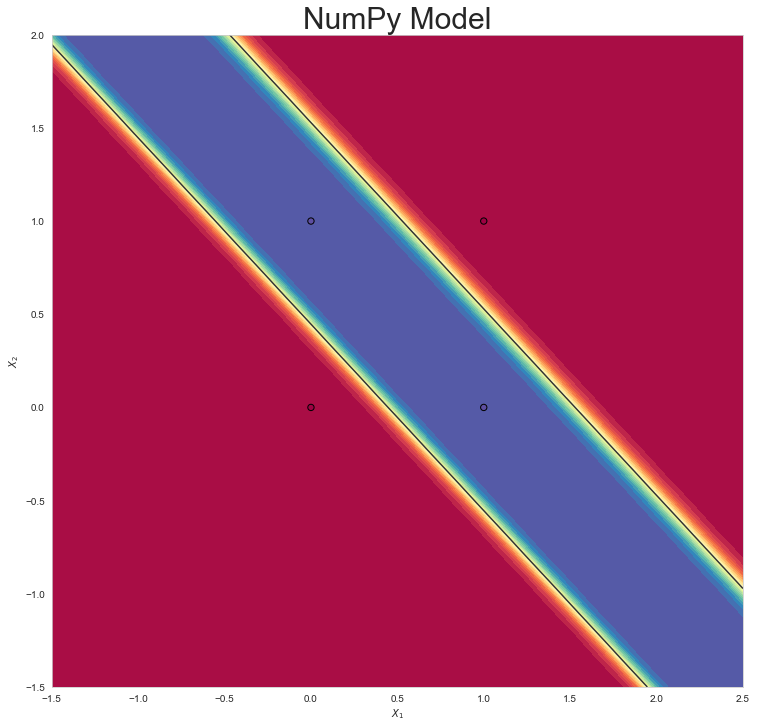

In [31]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_optimized, NN_ARCHITECTURE)
#print(prediction_probs_numpy)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)
